# ドルコスト平均法
1. 下がったら買い
2. 一定額を買う

## ランダムウォークのシリーズを作成

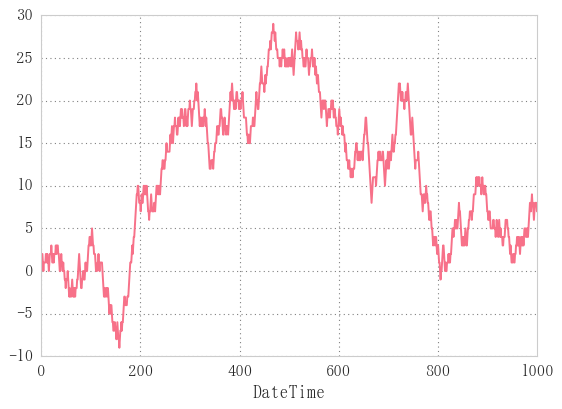

In [198]:
n = 1000
bullbear = pd.Series(np.random.randint(-1, 2, n))
price = bullbear.cumsum()
price.index.name='DateTime'
price.plot()

## 前日より値が低かったら買い、高かったら見過ごし
ドルコスト平均法の(1)

In [199]:
position = np.zeros(len(se))  # seと同じ長さの配列を作成
for i in price.index[:-1]:
    if price[i+1] - price[i] < 0:  # 前日の値のほうが小さければ高ければ安くなっているということ
        position[i]=price[i]  # そのときのpriceで買い
position

array([  0.,   0.,   0.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
         2.,   0.,   2.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   3.,
         2.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,
         0.,   3.,   0.,   2.,   1.,   0.,   0.,   0.,   2.,   0.,   1.,
         0.,   1.,   0.,   0.,   0.,  -1.,   0.,   0.,   0.,   0.,   0.,
        -1.,  -2.,   0.,  -2.,   0.,   0.,   0.,   0.,  -1.,  -2.,   0.,
        -2.,   0.,  -2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         2.,   1.,   0.,  -1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         4.,   0.,   0.,   0.,   5.,   4.,   0.,   3.,   0.,   0.,   2.,
         1.,   0.,   0.,   0.,   0.,   0.,   2.,   1.,   0.,   0.,   0.,
         0.,   0.,   1.,   0.,  -1.,  -2.,   0.,  -2.,   0.,   0.,   0.,
        -2.,   0.,   0.,  -2.,  -3.,  -4.,   0.,  -4.,   0.,   0.,  -4.,
        -5.,   0.,  -6.,   0.,   0.,   0.,  -6.,   

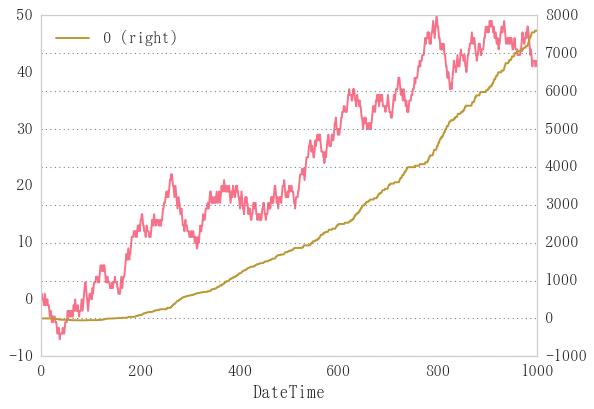

In [147]:
fig, ax = plt.subplots()
price.plot(ax=ax)
pd.DataFrame(position).cumsum().plot(ax=ax, secondary_y=True)  # ポジションのcumulative sumをプロット

### priceからbullbearの計算

In [148]:
def p2b(price):
    return price.sub(price.shift(1), fill_value=0)

In [149]:
np.array_equal(p2b(price), np.array(bullbear))

True

`p2b`関数によってbullbearの計算が可能となった。

## 効率化
前日の値より低かった日の終値だけを収集する関数

In [150]:
def dob(price):
    pos = np.zeros(len(price))  # priceと同じ長さの配列を作成
    for i in price.index[:-1]:
        if price[i+1]<price[i]:  # 前日の値より安ければ
            pos[i]=price[i]  # 買い
    return pos

In [151]:
%timeit dob(price)

10 loops, best of 3: 36.8 ms per loop


最もシンプル

In [152]:
%timeit [price[i] if price[i+1]<price[i] else 0 for i in price.index[:-1]]

10 loops, best of 3: 40.9 ms per loop


内包表記を用いても時間はあまり変わらない

In [153]:
def dob2(price):
    pos = np.zeros(len(price))  # priceと同じ長さの配列を作成
    pos = [price[i] if price.sub(price.shift(1), fill_value=0)<0 else 0]  # 下がったら買い
    return pos

In [154]:
price[np.array(bullbear)<0]  # bullbearが負の値になったところだけのpriceを収集

DateTime
3       0
6      -1
9       0
10     -1
12     -1
14     -1
17     -2
18     -3
21     -3
22     -4
24     -4
29     -4
32     -5
33     -6
37     -6
38     -7
45     -6
55     -3
57     -3
60     -3
62     -3
64     -3
67     -2
70     -1
71     -2
75     -2
77     -3
83     -1
84     -2
91      2
       ..
913    47
914    46
917    46
918    45
921    45
922    44
929    47
934    48
935    47
936    46
937    45
943    45
945    45
949    45
950    44
955    45
956    44
960    43
971    46
973    45
978    46
982    47
983    46
984    45
985    44
986    43
988    43
989    42
990    41
996    41
dtype: int32

In [155]:
def lowprice(price):
    """bullbearが負になったところだけのpriceを収集したpd.Seriesを返す"""
    return price[np.array(p2b(price))<0]

In [156]:
%timeit lowprice(price)

100 loops, best of 3: 3.24 ms per loop


pd.Serieesから直接引き出すので高速。10倍速を実現した

## 可視化

In [157]:
price.head()

DateTime
0    0
1    1
2    1
3    0
4    0
dtype: int32

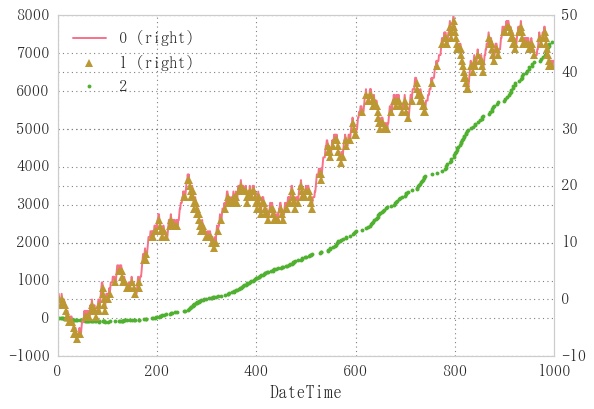

In [162]:
low = lowprice(price)
ax = pd.DataFrame([price, low, low.cumsum()]).T.plot(grid=True, style=['-', '^', '.'], secondary_y=[False, False, True])

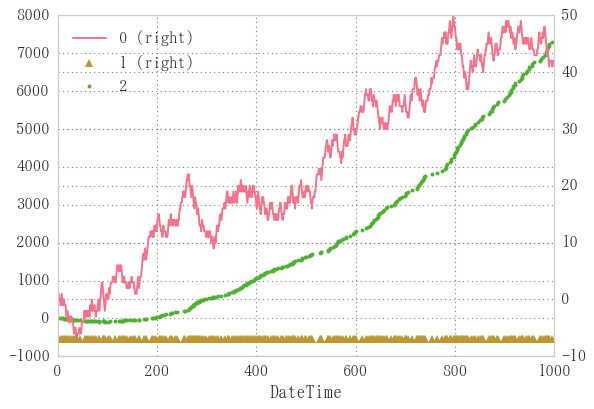

In [165]:
low = lowprice(price)
df = pd.DataFrame([price, pd.Series(np.zeros_like(low)+min(price), index=low.index), low.cumsum()]).T
df.plot(grid=True, style=['-', '^', '.'], secondary_y=[False, False, True])

## 特定期間で買い
毎週毎週購入かけているとお金が大量に必要になってしまう。

そんなに大量のお給料をもらっていないのである程度制限する。

ある週に1回でも購入したら、その週は条件が来ても購入を控えようと思う。

つまり来週になるまで「購入」の行動を無視するわけだね。

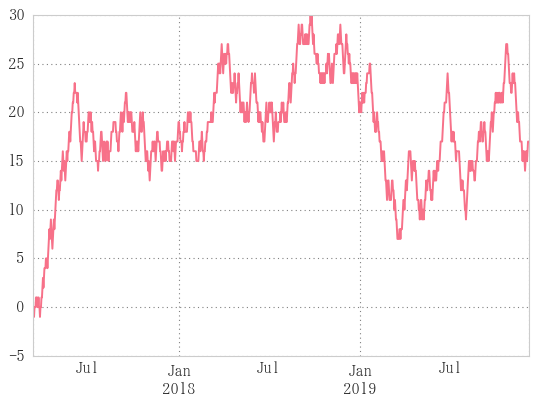

In [200]:
def randomwalk(periods, start=pd.datetime.today().date()):
    ts = pd.date_range(start=start, periods=periods)
    bullbear = pd.Series(np.random.randint(-1, 2, n), index=ts, name='DateTime')
    price = bullbear.cumsum()
    return price
price=randomwalk(1000)
price.plot()

In [193]:
p2b(price)

2017-03-12    1.0
2017-03-13    1.0
2017-03-14    1.0
2017-03-15   -1.0
2017-03-16   -1.0
2017-03-17   -1.0
2017-03-18    1.0
2017-03-19   -1.0
2017-03-20    1.0
2017-03-21    0.0
2017-03-22    0.0
2017-03-23    1.0
2017-03-24   -1.0
2017-03-25   -1.0
2017-03-26   -1.0
2017-03-27    0.0
2017-03-28   -1.0
2017-03-29    0.0
2017-03-30    0.0
2017-03-31    1.0
2017-04-01   -1.0
2017-04-02    0.0
2017-04-03    0.0
2017-04-04    1.0
2017-04-05    0.0
2017-04-06    1.0
2017-04-07    1.0
2017-04-08   -1.0
2017-04-09   -1.0
2017-04-10   -1.0
             ... 
2019-11-07    1.0
2019-11-08   -1.0
2019-11-09    1.0
2019-11-10   -1.0
2019-11-11    1.0
2019-11-12    0.0
2019-11-13    0.0
2019-11-14    1.0
2019-11-15    0.0
2019-11-16    1.0
2019-11-17    1.0
2019-11-18    1.0
2019-11-19    1.0
2019-11-20    1.0
2019-11-21   -1.0
2019-11-22    1.0
2019-11-23   -1.0
2019-11-24    1.0
2019-11-25    0.0
2019-11-26   -1.0
2019-11-27   -1.0
2019-11-28   -1.0
2019-11-29    1.0
2019-11-30    0.0
2019-12-01

In [ ]:
freq = 5 